In [1]:
import numpy as np
import vtk
import modules.utility as utility
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
import tables

Using TensorFlow backend.


In [2]:
mhas = open('images.txt').readlines()
mhas = [i.replace('\n','') for i in mhas]
# mhas = [i.split('/')[-1] for i in mhas]
# mhas = ['./data/'+i for i in mhas]

truths = open('truths.txt').readlines()
truths = [i.replace('\n','') for i in truths]

paths = open('paths.txt').readlines()
paths = [i.replace('\n','') for i in paths]

im_mr = open('mr_images.list').readlines()
im_mr = [i.replace('\n','') for i in im_mr]

im_ct = open('ct_images.list').readlines()
im_ct = [i.replace('\n','') for i in im_ct]

In [3]:
output_dir = "/media/marsdenlab/Data2/datasets/DeepLofting/"
ext = [191, 191]


In [4]:
def ct_norm(x):
    return (1.0*x+1000)/(2000)

def mr_norm(x):
    x = np.log(1.0*x-np.amin(x)+1)
    m = np.amin(x)
    x = (x-m)/(np.amax(x)-m)    
    return x

def image_reader(fn_tup):
    
    img_fn, truth_fn, path_fn = fn_tup
    reader = vtk.vtkMetaImageReader()
    reader2 = vtk.vtkMetaImageReader()
    
    img_name = img_fn.split('/')[-2]

    reader.SetFileName(img_fn)
    reader.Update()
    the_image = reader.GetOutput()

    model = truth_fn
    model_name = model.split('/')[-2]

    print img_fn,truth_fn

    reader2.SetFileName(model)
    reader2.Update()
    the_model = reader2.GetOutput()
    
    path_dict = utility.parsePathFile(path_fn)
    
    return (the_image,the_model,path_dict)

def process_image(data_tup, f_x, f_y, normalizer):
    the_image, the_model, path_dict = data_tup

    spacing = the_image.GetSpacing()
    dims = the_image.GetDimensions()
    origin = [-ext[0]*spacing[0]/2,ext[1]*spacing[1]/2]
    minmax = the_image.GetScalarRange()    

    tmpimages = utility.getAllImageSlices(the_image, path_dict, ext, True)
    tmpsegs = utility.getAllImageSlices(the_model, path_dict, ext, True)
    
    tmpimages = np.asarray(tmpimages)
    tmpsegs = np.asarray(tmpsegs)
    
    tmpimages = np.transpose(tmpimages,axes=(0,2,3,1))
    tmpsegs = np.transpose(tmpsegs,axes=(0,2,3,1))
    
    tmpimages = normalizer(tmpimages)
    tmpsegs = 1.0*tmpsegs/np.amax(tmpsegs)
    inds = [i for i in range(len(tmpimages)) if np.sum(tmpsegs[i])>0]
    print tmpimages.shape
    f_x.append(tmpimages[inds])
    f_y.append(tmpsegs[inds])

In [5]:
def images_to_hdf5(image_list,
                   reader, post_processor, normalizer,shape, label_shape, dtype, label_dtype,
                   output_fn):
    """
    takes a list of images, post processes them and stores result in extendable
    hdf5 table
    
    inputs:
        - image_list, (list of strings), list of image filenames, readable by reader
        - reader, (function), reader compatible with the file type in image_list
        - post_processor, (function), post processes output of reader, must return list of np arrays with same shape
        - output_fn, (string), ouput filename, must be hdf5 file
    """
    EXPECTED_ROWS = 10000
    
    #create hdf5 file
    hdf5_file = tables.open_file(output_fn,'w')
    filters = tables.Filters(complevel=5, complib='blosc')
    
    data_storage = hdf5_file.create_earray(hdf5_file.root,'X',
                                      tables.Atom.from_dtype(dtype),
                                      shape=[0]+list(shape),
                                         filters=filters,
                                         expectedrows=EXPECTED_ROWS)
    
    label_storage = hdf5_file.create_earray(hdf5_file.root,'Y',
                                      tables.Atom.from_dtype(label_dtype),
                                      shape=[0]+list(label_shape),
                                         filters=filters,
                                         expectedrows=EXPECTED_ROWS)
        
    for i in range(len(image_list)):
        print 'image {}'.format(i)
        data_tuple = reader(image_list[i])
        
        post_processor(data_tuple,data_storage,label_storage,normalizer)
            
    hdf5_file.close()

In [6]:
train_ct = '/media/marsdenlab/Data2/datasets/DeepLofting/train_192_ct.hdf5'
val_ct = '/media/marsdenlab/Data2/datasets/DeepLofting/val_192_ct.hdf5'
test_ct = '/media/marsdenlab/Data2/datasets/DeepLofting/test_192_ct.hdf5'

train_mr = '/media/marsdenlab/Data2/datasets/DeepLofting/train_192_mr.hdf5'
val_mr = '/media/marsdenlab/Data2/datasets/DeepLofting/val_192_mr.hdf5'
test_mr = '/media/marsdenlab/Data2/datasets/DeepLofting/test_192_mr.hdf5'

In [7]:
ct_inds = [i for i in range(len(mhas)) if any([c in mhas[i] for c in im_ct])]
mr_inds = [i for i in range(len(mhas)) if any([c in mhas[i] for c in im_mr])]
ct_fn_tup = [(mhas[i],truths[i],paths[i]) for i in ct_inds]
mr_fn_tup = [(mhas[i],truths[i],paths[i]) for i in mr_inds]

print ct_fn_tup
print mr_fn_tup

[('/home/marsdenlab/datasets/vascular_data/OSMSC0001/OSMSC0001-cm.mha', '/home/marsdenlab/datasets/vascular_data/OSMSC0001/0001_0001/0001_0001-cm.mha', '/home/marsdenlab/datasets/vascular_data/OSMSC0001/0001_0001/0001_0001-cm.paths'), ('/home/marsdenlab/datasets/vascular_data/OSMSC0002/OSMSC0002-cm.mha', '/home/marsdenlab/datasets/vascular_data/OSMSC0002/0002_0001/0002_0001-cm.mha', '/home/marsdenlab/datasets/vascular_data/OSMSC0002/0002_0001/0002_0001-cm.paths'), ('/home/marsdenlab/datasets/vascular_data/OSMSC0003/OSMSC0003-cm.mha', '/home/marsdenlab/datasets/vascular_data/OSMSC0003/0003_0001/0003_0001-cm.mha', '/home/marsdenlab/datasets/vascular_data/OSMSC0003/0003_0001/0003_0001-cm.paths'), ('/home/marsdenlab/datasets/vascular_data/OSMSC0004/OSMSC0004-cm.mha', '/home/marsdenlab/datasets/vascular_data/OSMSC0004/0004_0001/0004_0001-cm.mha', '/home/marsdenlab/datasets/vascular_data/OSMSC0004/0004_0001/0004_0001-cm.paths'), ('/home/marsdenlab/datasets/vascular_data/OSMSC0005/OSMSC0005-c

In [8]:
from random import shuffle
inds = range(len(ct_fn_tup))
shuffle(inds)
shuf_image = [ct_fn_tup[i] for i in inds]

L = len(ct_fn_tup)
print L
cuts = [int(0.7*L), int(0.8*L), L]
print cuts

print "train"
print shuf_image[:cuts[0]]

print "val"
print shuf_image[cuts[0]:cuts[1]]

print "test"
print shuf_image[cuts[1]:cuts[2]]

49
[34, 39, 49]
train
[('/home/marsdenlab/datasets/vascular_data/OSMSC0168/OSMSC0168-cm.mha', '/home/marsdenlab/datasets/vascular_data/OSMSC0168/0168_0001/0168_0001-cm.mha', '/home/marsdenlab/datasets/vascular_data/OSMSC0168/0168_0001/0168_0001-cm.paths'), ('/home/marsdenlab/datasets/vascular_data/OSMSC0004/OSMSC0004-cm.mha', '/home/marsdenlab/datasets/vascular_data/OSMSC0004/0004_0001/0004_0001-cm.mha', '/home/marsdenlab/datasets/vascular_data/OSMSC0004/0004_0001/0004_0001-cm.paths'), ('/home/marsdenlab/datasets/vascular_data/OSMSC0185/OSMSC0185-cm.mha', '/home/marsdenlab/datasets/vascular_data/OSMSC0185/0185_0001/0185_0001-cm.mha', '/home/marsdenlab/datasets/vascular_data/OSMSC0185/0185_0001/0185_0001-cm.paths'), ('/home/marsdenlab/datasets/vascular_data/OSMSC0187/OSMSC0187-cm.mha', '/home/marsdenlab/datasets/vascular_data/OSMSC0187/0187_0002/0187_0002-cm.mha', '/home/marsdenlab/datasets/vascular_data/OSMSC0187/0187_0002/0187_0002-cm.paths'), ('/home/marsdenlab/datasets/vascular_data

In [9]:
d = np.dtype(np.float16)
images_to_hdf5(shuf_image[:cuts[0]],
                   image_reader,
                   process_image, ct_norm, (ext[0]+1,ext[0]+1,1), (ext[0]+1,ext[1]+1,1), d, d,
                   train_ct)

images_to_hdf5(shuf_image[cuts[0]:cuts[1]],
                   image_reader,
                   process_image, ct_norm, (ext[0]+1,ext[1]+1,1), (ext[0]+1,ext[1]+1,1),d, d,
                   val_ct)

images_to_hdf5(shuf_image[cuts[1]:cuts[2]],
                   image_reader,
                   process_image, ct_norm, (ext[0]+1,ext[1]+1,1), (ext[0]+1,ext[1]+1,1), d, d,
                   test_ct)

image 0
/home/marsdenlab/datasets/vascular_data/OSMSC0168/OSMSC0168-cm.mha /home/marsdenlab/datasets/vascular_data/OSMSC0168/0168_0001/0168_0001-cm.mha
(7300, 192, 192, 1)
image 1
/home/marsdenlab/datasets/vascular_data/OSMSC0004/OSMSC0004-cm.mha /home/marsdenlab/datasets/vascular_data/OSMSC0004/0004_0001/0004_0001-cm.mha
(1700, 192, 192, 1)
image 2
/home/marsdenlab/datasets/vascular_data/OSMSC0185/OSMSC0185-cm.mha /home/marsdenlab/datasets/vascular_data/OSMSC0185/0185_0001/0185_0001-cm.mha
(2400, 192, 192, 1)
image 3
/home/marsdenlab/datasets/vascular_data/OSMSC0187/OSMSC0187-cm.mha /home/marsdenlab/datasets/vascular_data/OSMSC0187/0187_0002/0187_0002-cm.mha
(1700, 192, 192, 1)
image 4
/home/marsdenlab/datasets/vascular_data/OSMSC0142/OSMSC0142-cm.mha /home/marsdenlab/datasets/vascular_data/OSMSC0142/0142_1001/0142_1001-cm.mha
(5900, 192, 192, 1)
image 5
/home/marsdenlab/datasets/vascular_data/OSMSC0113/OSMSC0113-cm.mha /home/marsdenlab/datasets/vascular_data/OSMSC0113/0113_0003/0113_

(25200, 192, 192, 1)
image 9
/home/marsdenlab/datasets/vascular_data/OSMSC0115/OSMSC0115-cm.mha /home/marsdenlab/datasets/vascular_data/OSMSC0115/0115_0005/0115_0005-cm.mha
(4250, 192, 192, 1)


In [10]:
from random import shuffle
inds = range(len(mr_fn_tup))
shuffle(inds)
shuf_image = [mr_fn_tup[i] for i in inds]

L = len(mr_fn_tup)
print L
cuts = [int(0.7*L), int(0.8*L), L]
print cuts

print "train"
print shuf_image[:cuts[0]]

print "val"
print shuf_image[cuts[0]:cuts[1]]

print "test"
print shuf_image[cuts[1]:cuts[2]]

48
[33, 38, 48]
train
[('/home/marsdenlab/datasets/vascular_data/OSMSC0006/OSMSC0006-cm.mha', '/home/marsdenlab/datasets/vascular_data/OSMSC0006/0006_0001/0006_0001-cm.mha', '/home/marsdenlab/datasets/vascular_data/OSMSC0006/0006_0001/0006_0001-cm.paths'), ('/home/marsdenlab/datasets/vascular_data/OSMSC0169/OSMSC0169-cm.mha', '/home/marsdenlab/datasets/vascular_data/OSMSC0169/0169_0002/0169_0002-cm.mha', '/home/marsdenlab/datasets/vascular_data/OSMSC0169/0169_0002/0169_0002-cm.paths'), ('/home/marsdenlab/datasets/vascular_data/OSMSC0131/OSMSC0131-cm.mha', '/home/marsdenlab/datasets/vascular_data/OSMSC0131/0131_0000/0131_0000-cm.mha', '/home/marsdenlab/datasets/vascular_data/OSMSC0131/0131_0000/0131_0000-cm.paths'), ('/home/marsdenlab/datasets/vascular_data/OSMSC0074/OSMSC0074-cm.mha', '/home/marsdenlab/datasets/vascular_data/OSMSC0074/0074_0001/0074_0001-cm.mha', '/home/marsdenlab/datasets/vascular_data/OSMSC0074/0074_0001/0074_0001-cm.paths'), ('/home/marsdenlab/datasets/vascular_data

In [11]:
d = np.dtype(np.float16)
images_to_hdf5(shuf_image[:cuts[0]],
                   image_reader,
                   process_image, mr_norm, (ext[0]+1,ext[0]+1,1), (ext[0]+1,ext[1]+1,1), d, d,
                   train_mr)

images_to_hdf5(shuf_image[cuts[0]:cuts[1]],
                   image_reader,
                   process_image, mr_norm, (ext[0]+1,ext[1]+1,1), (ext[0]+1,ext[1]+1,1),d, d,
                   val_mr)

images_to_hdf5(shuf_image[cuts[1]:cuts[2]],
                   image_reader,
                   process_image, mr_norm, (ext[0]+1,ext[1]+1,1), (ext[0]+1,ext[1]+1,1), d, d,
                   test_mr)

image 0
/home/marsdenlab/datasets/vascular_data/OSMSC0006/OSMSC0006-cm.mha /home/marsdenlab/datasets/vascular_data/OSMSC0006/0006_0001/0006_0001-cm.mha
(875, 192, 192, 1)
image 1
/home/marsdenlab/datasets/vascular_data/OSMSC0169/OSMSC0169-cm.mha /home/marsdenlab/datasets/vascular_data/OSMSC0169/0169_0002/0169_0002-cm.mha
(11550, 192, 192, 1)
image 2
/home/marsdenlab/datasets/vascular_data/OSMSC0131/OSMSC0131-cm.mha /home/marsdenlab/datasets/vascular_data/OSMSC0131/0131_0000/0131_0000-cm.mha
(1700, 192, 192, 1)
image 3
/home/marsdenlab/datasets/vascular_data/OSMSC0074/OSMSC0074-cm.mha /home/marsdenlab/datasets/vascular_data/OSMSC0074/0074_0001/0074_0001-cm.mha
(700, 192, 192, 1)
image 4
/home/marsdenlab/datasets/vascular_data/OSMSC0163/OSMSC0163-cm.mha /home/marsdenlab/datasets/vascular_data/OSMSC0163/0163_0001/0163_0001-cm.mha
(3850, 192, 192, 1)
image 5
/home/marsdenlab/datasets/vascular_data/OSMSC0171/OSMSC0171-cm.mha /home/marsdenlab/datasets/vascular_data/OSMSC0171/0171_0001/0171_0

(15800, 192, 192, 1)


In [12]:
f = tables.open_file(train_ct, 'r')

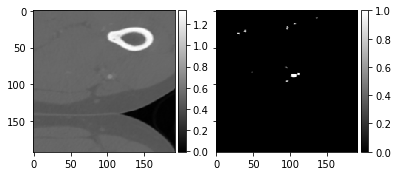

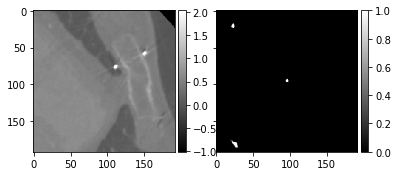

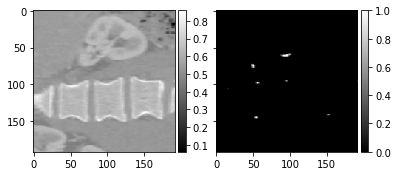

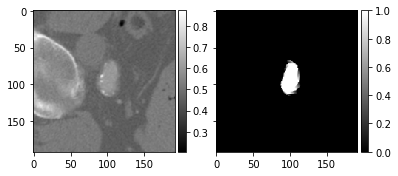

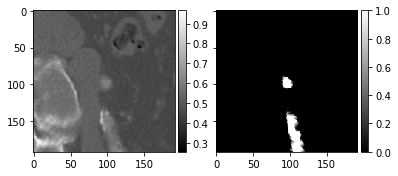

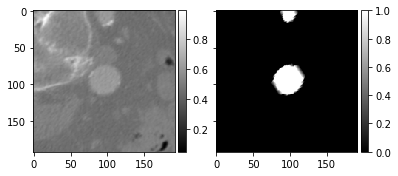

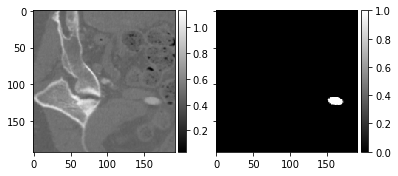

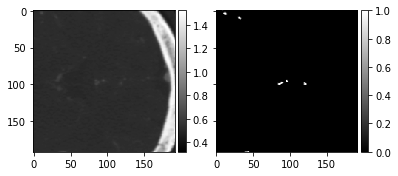

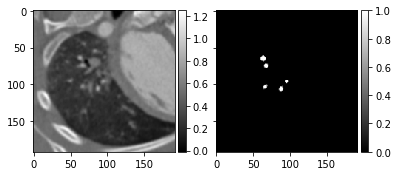

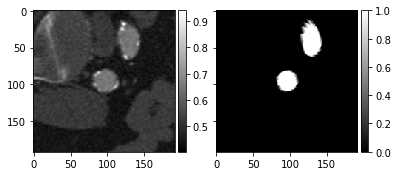

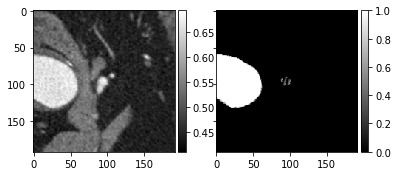

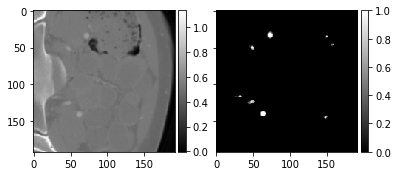

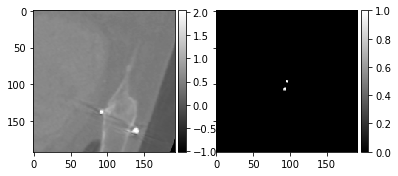

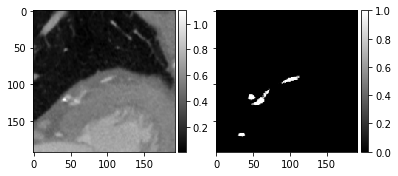

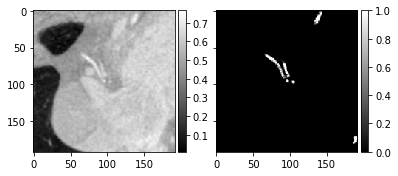

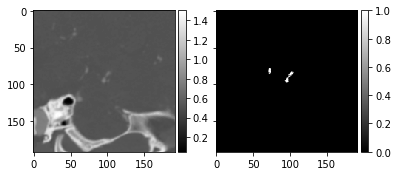

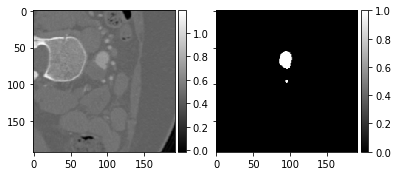

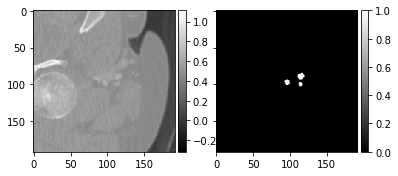

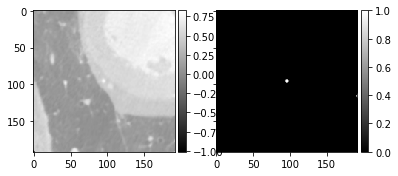

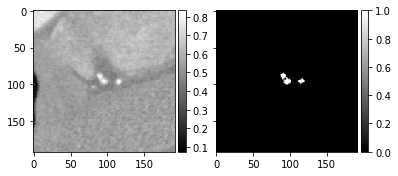

In [13]:
def implot(mp,ax):
    im = ax.imshow(mp.astype(np.float32), cmap='gray')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(im, cax=cax)
    
for i in range(20):
    j = np.random.randint(len(f.root.X))

    plt.figure()
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
    implot(f.root.X[j,:,:,0],ax1)
    implot(f.root.Y[j,:,:,0],ax2)

    plt.tight_layout
    plt.show()
    
plt.close('all')

In [17]:
path_dict = utility.parsePathFile(paths[0])

In [18]:
print path_dict

{'200': {'points': array([[  2.32900000e-01,   1.78400000e-01,  -1.85725000e+01, ...,
          0.00000000e+00,   9.99979000e-01,  -6.50200000e-03],
       [  2.33019000e-01,   1.78446000e-01,  -1.85631840e+01, ...,
          0.00000000e+00,   9.99993000e-01,  -3.82600000e-03],
       [  2.33443000e-01,   1.78508000e-01,  -1.85364170e+01, ...,
          0.00000000e+00,   1.00000000e+00,  -7.56000000e-04],
       ..., 
       [  6.14020100e+00,  -1.05412300e+00,  -1.24546830e+01, ...,
          0.00000000e+00,   9.19807000e-01,   3.92371000e-01],
       [  6.16648400e+00,  -1.04618300e+00,  -1.24733310e+01, ...,
          0.00000000e+00,   9.20177000e-01,   3.91503000e-01],
       [  6.20330000e+00,  -1.03500000e+00,  -1.24996000e+01, ...,
          0.00000000e+00,   9.20076000e-01,   3.91739000e-01]]), 'name': 'brchcph'}, '900': {'points': array([[ -1.25550000e+00,   2.71710000e+00,   4.81120000e+00,
          5.27392000e-01,   6.17560000e-01,   5.83504000e-01,
          0.00000000e+00

In [22]:
print path_dict['200']
print type(path_dict['200']['points'])

{'points': array([[  2.32900000e-01,   1.78400000e-01,  -1.85725000e+01, ...,
          0.00000000e+00,   9.99979000e-01,  -6.50200000e-03],
       [  2.33019000e-01,   1.78446000e-01,  -1.85631840e+01, ...,
          0.00000000e+00,   9.99993000e-01,  -3.82600000e-03],
       [  2.33443000e-01,   1.78508000e-01,  -1.85364170e+01, ...,
          0.00000000e+00,   1.00000000e+00,  -7.56000000e-04],
       ..., 
       [  6.14020100e+00,  -1.05412300e+00,  -1.24546830e+01, ...,
          0.00000000e+00,   9.19807000e-01,   3.92371000e-01],
       [  6.16648400e+00,  -1.04618300e+00,  -1.24733310e+01, ...,
          0.00000000e+00,   9.20177000e-01,   3.91503000e-01],
       [  6.20330000e+00,  -1.03500000e+00,  -1.24996000e+01, ...,
          0.00000000e+00,   9.20076000e-01,   3.91739000e-01]]), 'name': 'brchcph'}
<type 'numpy.ndarray'>


In [23]:
img_fn = mhas[0]
truth_fn = truths[0]
path_fn = paths[0]
reader = vtk.vtkMetaImageReader()
reader2 = vtk.vtkMetaImageReader()

img_name = img_fn.split('/')[-2]

reader.SetFileName(img_fn)
reader.Update()
the_image = reader.GetOutput()

model = truth_fn
model_name = model.split('/')[-2]

print img_fn,truth_fn

reader2.SetFileName(model)
reader2.Update()
the_model = reader2.GetOutput()

path_dict = utility.parsePathFile(path_fn)

/home/marsdenlab/datasets/vascular_data/OSMSC0001/OSMSC0001-cm.mha /home/marsdenlab/datasets/vascular_data/OSMSC0001/0001_0001/0001_0001-cm.mha


In [25]:
normalizer = ct_norm
spacing = the_image.GetSpacing()
dims = the_image.GetDimensions()
origin = [-ext[0]*spacing[0]/2,ext[1]*spacing[1]/2]
minmax = the_image.GetScalarRange()    

tmpimages = utility.getAllImageSlices(the_image, path_dict, ext, True)
tmpsegs = utility.getAllImageSlices(the_model, path_dict, ext, True)

tmpimages = np.asarray(tmpimages)
tmpsegs = np.asarray(tmpsegs)

tmpimages = np.transpose(tmpimages,axes=(0,2,3,1))
tmpsegs = np.transpose(tmpsegs,axes=(0,2,3,1))

tmpimages = normalizer(tmpimages)
tmpsegs = 1.0*tmpsegs/np.amax(tmpsegs)
inds = [i for i in range(len(tmpimages)) if np.sum(tmpsegs[i])>0]

In [28]:
print len(tmpimages)
print len(tmpsegs)
print len(inds)
print tmpsegs[0].shape

2700
2700
300
(192, 192, 1)
